# MLP for Character Level Language Model

In the last section we built a bigram model. In this section we are going to build a character level language model using MLP. Instead of considering ONLY the previous character, we are going to consider multiple characters. We are going to follow this paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

## Understanding the Model as described in the paper

At a very high level, the model describes a vocabulary of 17000 words and is trained to learn the probability of each word given the 3 previous word in a sentence. It has 17000 output neurons, x amount of neurons in the hidden layer and a 30 X 1 vector for each word. Let us do the implementation of this model to understand the details. The idea is that through the embedding space, we are able to capture the semantic meaning of the words and use it to predict the next word in the sentence. Embedding space is a space where each word is represented by a vector. In this paper the vector's size is 30.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [ ]:
_words = open("names.txt", "r").read().splitlines()
_words[:8]

In [ ]:
# Build the vocabulary of characters
_chars = sorted(list(set(''.join(_words))))
_stoi = {s:i + 1 for i,s in enumerate(_chars)}
_stoi['.'] = 0
_itos = {i:s for s,i in _stoi.items()}

In [ ]:
# Creating the Dataset
_block_size = 3 # This is the context length of how many characters we use to predict the next character

_X, _Y = [], []

for _w in _words:
    _context = ['.'] * _block_size
    _w = _context + list(_w) + ['.']

    for _i in range(len(_w) - _block_size):
        _current_context = _w[_i:_i+_block_size]
        _target = _w[_i+_block_size]
        _X.append([_stoi[c] for c in _current_context])
        _Y.append(_stoi[_target])

_X = torch.tensor(_X)
_Y = torch.tensor(_Y)
_X.shape, _Y.shape

Tensors should always be of floats or integer to feed to the model. The difference in our implementation is, that we are still predicting the characters instead of the words. In the paper the vocabulary size is 17000 and the embedding space is of size 17000 x 30. In our implementatio the vocubalry size is 27 and the embedding space we will create is 27 x 2.

In [ ]:
# C represents the embedding table space
_C = torch.randn((27, 2))

# Now that we have created the lookup table, we need a way to GET the embedding vector for a given character. These are the 2 ways.
print(F.one_hot(torch.tensor(5), num_classes=27).float() @ _C)
print(_C[5])

# We will be using the second way.

To make plucking out values from the C map easy, let us understand how indexing works in pytorch. The below example shows that we can index a tensor using a list of indices easily. Using indexing we can input all of the Xs into the embedding table and get the vectors.

In [ ]:
_emb = _C[_X]
_emb.shape

Now lets construct the hidden layer. First let us understand the dimensions of the hidden layer.

Let us think of 1 neuron. 1 neuron will get 3 characters (ch1, ch2, ch3) and each character has 2 dimensions of embedding space (c1, c2). Therefore for each neuron the equation will be:


$Z = W_1 c_{11} + W_2 c_{12} + W_3 c_{21} + W_4 c_{22} + W_5 c_{31} + W_6 c_{32} + b$

Therefore, the hidden layer's weights for 1 neuron will be of size 6 and the bias will be of size 1. The number of neurons in the hidden layer is a hyperparameter.

In [ ]:
# Now we construct the hidden layer
_W1 = torch.randn((6, 100))
_b1 = torch.randn((1, 100))


Since our embedding is of the shape, 32 x 3 x 2, we need to flatten it to 32 x 6. We can use concat and unbind but there is much better and faster way to do it.

In pytorch, we can use view to flatten the tensor. Internally every tensor in pytorch has something called a storage. The storage is the representation of the tensor in a 1D array. When we use view or print a tensor, the flat array of bytes remain unchanged but the internal representation of the tensor changes. With views, there is no copying of data and hence it is very fast. 

In our case, we want to just represent our 32 x 3 x 2 tensor as 32 x 6 tensor. We can use view to do this. Te view operation works right to left.

In [ ]:
# Let us try some torch operation
print(_emb[:, 0, :].shape) # This will give us the embedding of the first character of each sequence.

_a = torch.arange(8)
print(_a)
print(_a.view(2, 4)) # We can very easily reshape the tensor. .view is VERY efficient.

In [ ]:
# This is the hidden layer 1
_h = torch.tanh(_emb.view(-1, 6) @ _W1 + _b1)

In [ ]:
_W2 = torch.randn(100, 27)
_b2 = torch.randn(27)

In [ ]:
_logits = _h @ _W2 + _b2
_logits.shape

In [ ]:
# Now we can perform the softmax operation
_counts = _logits.exp()
_probs = _counts / _counts.sum(dim=1, keepdim=True)
_loss = -_probs[torch.arange(_X.shape[0]), _Y].log().mean()

_loss

## Concise Implementation

This piece of code is called the Cross Entropy loss.
````
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(X.shape[0]), Y].log().mean()
````

 We calculated this loss manually in the bigram model. But using pytorch's internal method has added advantages:

 1. It does not create these intermediate tensors, which saves significant amount of memory.
 2. The backward pass can be made much simpler.
 3. If the logits are somehow very large or very small, we can run into numerical underflow and overflow which results in NaN operation when doing .exp(). Pytorch's implementation is more numerically stable. What PyTorch does and what we have learnt already is that we subtract all logit values with the maximum of the logits to create a value less than 1. This is called log-sum-exp trick.

### Optimising the Training Loop
We can see that 100 iterations is taking roughly around 15 seconds to run the forward and the backward pass. To make gradient descent a little better, we can do minibatch gradient descent. In this we take a minibatch of data and then perform the forward pass.

### Finding a good learning rate
Having a good learning rate really will help the model train betetr and faster. For this we can create a linspace of learning rates and then perform gradient descent for each of them and see which one converges the fastest. Usually during training people like to do learning rate decay, i.e. reduce the learning rate after some epochs.

### Splitting dataset
As the capability of the neural network increases, becuase of the number of parameters, the NN is at the risk of something called overfitting. Overfitting means that it has trained or learnt the training data too well and is not able to generalise to new data. For this, We usually try to split the dataset into training, validation and test set. Training set is used to train the model, validation set is used to tune the hyperparameters and test set is used to evaluate the model.

### Experimenting with large hidden layer outputs

We can see that the hidden layer outputs are not that large. We can try to increase the hidden layer outputs to see if it helps the model to learn better. We bring the loss to roughly around 2.2.

In [2]:
# Global Variables
g = torch.Generator().manual_seed(2147483647)
block_size = 3
emb_size = 2

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:8]

# Build the vocabulary of characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
def get_dataset(words):
    # Creating the Dataset
    block_size = 3 # This is the context length of how many characters we use to predict the next character

    X, Y = [], []

    for w in words:
        context = ['.'] * block_size
        w = context + list(w) + ['.']

        for i in range(len(w) - block_size):
            current_context = w[i:i+block_size]
            target = w[i+block_size]
            X.append([stoi[c] for c in current_context])
            Y.append(stoi[target])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [5]:
def get_params():
    # Let us create a more easy to read forward pass and loss function for the neural network.
    C = torch.randn((27, emb_size), generator=g, requires_grad=True)

    W1 = torch.randn((block_size * emb_size, 200), generator=g, requires_grad=True)
    b1 = torch.randn((1, 200), generator=g, requires_grad=True)


    W2 = torch.randn((200, 27), generator=g, requires_grad=True)
    b2 = torch.randn((1, 27), generator=g, requires_grad=True)

    print(torch.tensor([i.nelement() for i in[C, W1, b1, W2, b2]]).sum())
    return C, W1, b1, W2, b2

In [6]:
def training_loop(X, Y, lr, params):
        # Training Loop
    C, W1, b1, W2, b2 = params
    for _ in range(50000):
    # Forward Pass
        ix = torch.randint(0, X.shape[0], (32,), generator=g)
        emb = C[X[ix]]
        h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])
        # Backward Pass
        for p in params:
            p.grad = None
        loss.backward()

        lr = 0.1
        for p in params:
            p.data += -lr * p.grad

In [7]:
def get_loss(params, X, Y):
    C, W1, b1, W2, b2 = params
    emb = C[X]
    h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

In [8]:
# Now we can create the training, validation and test splits.
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = get_dataset(words[:n1])
Xdev, Ydev = get_dataset(words[n1:n2])
Xte, Yte = get_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
params = get_params()

tensor(6881)


In [14]:
for _ in range(1):
    # Training using the training set
    training_loop(Xtr, Ytr, 0.05, params)

get_loss(params, Xtr, Ytr)

tensor(2.2855, grad_fn=<NllLossBackward0>)

In [15]:
get_loss(params, Xdev, Ydev)

tensor(2.3032, grad_fn=<NllLossBackward0>)

### Visualizing the Character Embedding

We can visualuze the character embedding since its a 2D vector. With this we can see what our character model has learnt. If we see the visualization, we can notice a few patterns:

1. The vowels are close to each other which means that our neural network learnt that vowels are similar to each other.
2. Characters like q or . have their own special embeddings and everything is clustered.

Now we will scale up the size of our embedding.

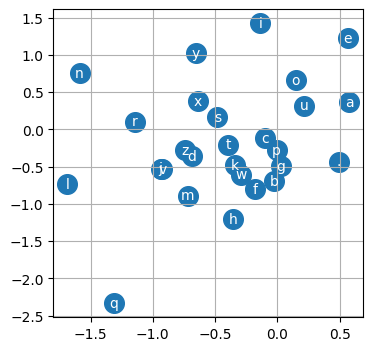

In [16]:
plt.figure(figsize=(4, 4))
C, W1, b1, W2, b2 = params
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")

plt.grid('minor')
plt.show()

In [17]:
emb_size = 10
params = get_params()

tensor(11897)


In [20]:

for _ in range(1):
    # Training using the training set
    training_loop(Xtr, Ytr, 0.05, params)

get_loss(params, Xtr, Ytr)

tensor(2.2283, grad_fn=<NllLossBackward0>)

In [21]:
get_loss(params, Xdev, Ydev)

tensor(2.2787, grad_fn=<NllLossBackward0>)

### Making Predictions

Using the model we have trained, let us try and make predictions.

In [22]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amo.
heri.
kemri.
rey.
caspanda.
ejrahnee.
delyn.
charqui.
nelinia.
chaily.
kaleig.
dham.
forn.
quinn.
sro.
kea.
rad.
quinatho.
dearyn.
